In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

In [2]:
f = h5py.File('../data/fof_subhalo_tab_033.hdf5')
f.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

In [3]:
f['Header'].attrs.keys()

<KeysViewHDF5 ['BoxSize', 'FlagDoubleprecision', 'Git_commit', 'Git_date', 'HubbleParam', 'Ngroups_ThisFile', 'Ngroups_Total', 'Nids_ThisFile', 'Nids_Total', 'Nsubgroups_ThisFile', 'Nsubgroups_Total', 'NumFiles', 'Omega0', 'OmegaLambda', 'Redshift', 'Time']>

In [4]:
f['Subhalo'].attrs.keys()

<KeysViewHDF5 []>

In [5]:
SM    = f['/Subhalo/SubhaloMassType'][:, 4]*1e10 #Msun/h
mags = f['Subhalo/SubhaloStellarPhotometrics'][:]
SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
R_g  =  f['Subhalo/SubhaloHalfmassRadType'][:, 4] #kpc/h

In [6]:
threshold = 1.e8

In [7]:
indexes = np.where(SM > threshold)[0]
SM      = SM[indexes]
mags    = mags[indexes]
SFR     = SFR[indexes]
R_g     = R_g[indexes]
indexes.shape

(860,)

In [8]:
color = mags[:,4]-mags[:,5]

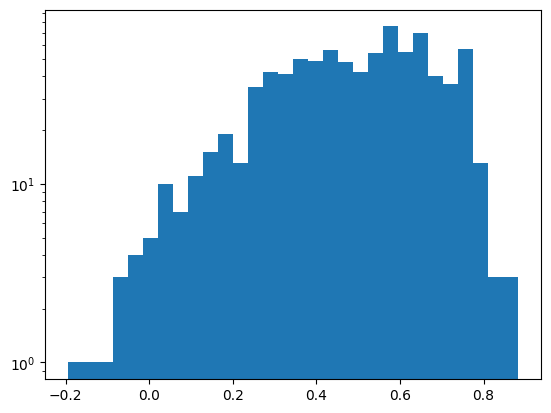

In [9]:
plt.figure(dpi = 100)
plt.hist(color, bins = 30)
plt.yscale('log')

In [10]:
SFR[np.where(SFR == 0)[0]] = 10**(8)

In [11]:
color[np.where(color < 0.6)[0]] = int(0)
color[np.where(color > 0.6)[0]] = int(1)

In [12]:
#Galaxy catalog
data = np.array( [ np.log10(SM), color, np.log10(SFR), R_g ] ).T
columns = [ 'SM', 'color', 'SFR', 'R' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,SM,color,SFR,R
0,11.630214,1.0,8.000000,30.098984
1,10.379946,0.0,10.230370,3.347014
2,10.190658,0.0,9.343358,4.301775


In [13]:
gals.describe()

,SM,color,SFR,R
count,860.000000,860.000000,860.000000,860.000000
mean,9.006678,0.313953,8.747816,4.378883
std,0.766523,0.464368,0.752413,2.179333
min,8.000628,0.000000,7.499816,0.358295
25%,8.341695,0.000000,8.000000,3.064089
50%,8.849222,0.000000,8.639319,3.973066
75%,9.545236,1.000000,9.395308,5.232606
max,11.630214,1.000000,10.878436,30.098984


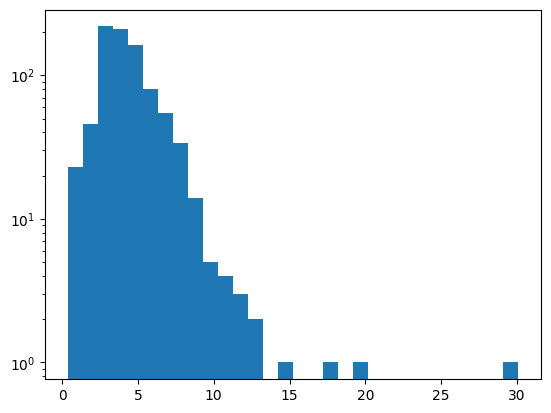

In [14]:
plt.figure(dpi = 100)
plt.hist(gals['R'], bins = 30)
plt.yscale('log')

In [15]:
gals = gals.sample(frac = 1)

In [16]:
X = np.array([gals['SM'], gals['SFR'], gals['R']]).T
y = np.array(gals['color'])
X.shape, y.shape

((860, 3), (860,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
model = RandomForestClassifier(random_state = 42, class_weight = 'balanced')

In [19]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [20]:
FI = model.feature_importances_

Text(0.5, 0, 'feature importance')

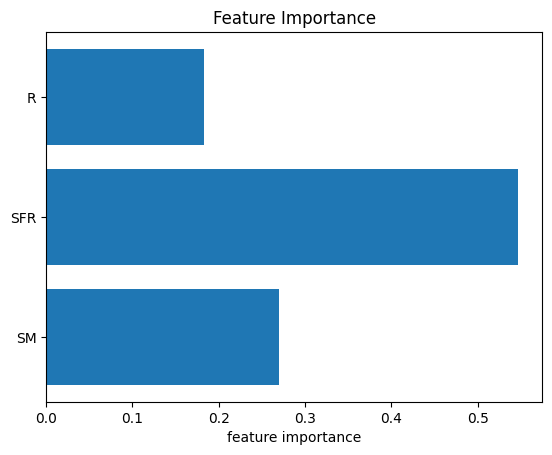

In [21]:
plt.figure(dpi = 100)
plt.title('Feature Importance')
plt.barh(['SM', 'SFR', 'R'], FI)
plt.xlabel('feature importance')

In [22]:
pred = model.predict(X_test)

In [23]:
#Evaluating the model
accuracy = accuracy_score(pred, y_test)
precision = precision_score(pred, y_test)
recall = recall_score(pred, y_test)
f1 = f1_score(pred, y_test)
roc_auc = roc_auc_score(pred, y_test)
cm = confusion_matrix(pred, y_test)

In [24]:
# Print results
print(f"TEST Accuracy: {accuracy:.4f}")
print(f"TEST Precision: {precision:.4f}")
print(f"TEST Recall: {recall:.4f}")
print(f"TEST F1-Score: {f1:.4f}")
print(f"TEST ROC AUC Score: {roc_auc:.4f}")

TEST Accuracy: 0.8663
TEST Precision: 0.7222
TEST Recall: 0.8298
TEST F1-Score: 0.7723
TEST ROC AUC Score: 0.8549


Text(0.5, 23.52222222222222, 'Predicted')

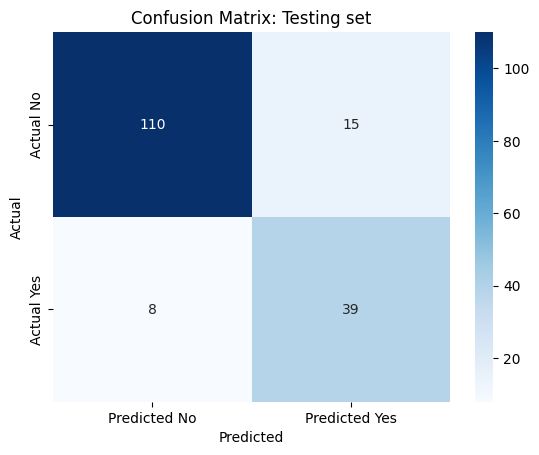

In [25]:
# VTest set
plt.figure(dpi = 100)
plt.title('Confusion Matrix: Testing set')
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
            xticklabels = ['Predicted No', 'Predicted Yes'], yticklabels = ['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')